In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
import cv2
from PIL import Image

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
#from torchvision.transforms import v2
from torchvision import transforms , datasets, models
import torch.nn.functional as F # activation function

from torch.utils.data import DataLoader, random_split
from torchsummary import summary

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
DEVICE

device(type='cuda')

In [3]:
train_dir = './train'
classes = os.listdir(train_dir)[:38]
print(classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',

In [4]:
def image_count(data_dir):
    print(f'\nTrain Counting Images in Category set :')
        
    # Iterate over each category (subfolder) in the split
        
    for sub_path in sorted(os.listdir(data_dir)):
        sub_cat = os.path.join(data_dir,sub_path)
        # Count the number of files, assuming they are all images
        num_images = len([name for name in os.listdir(sub_cat) if os.path.isfile(
                os.path.join(sub_cat, name))])
        print(f"    {sub_path}: {num_images} images")

image_count(train_dir)


Train Counting Images in Category set :
    Apple___Apple_scab: 2016 images
    Apple___Black_rot: 1987 images
    Apple___Cedar_apple_rust: 1760 images
    Apple___healthy: 2008 images
    Blueberry___healthy: 1816 images
    Cherry_(including_sour)___Powdery_mildew: 1683 images
    Cherry_(including_sour)___healthy: 1826 images
    Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 1642 images
    Corn_(maize)___Common_rust_: 1907 images
    Corn_(maize)___Northern_Leaf_Blight: 1908 images
    Corn_(maize)___healthy: 1859 images
    Grape___Black_rot: 1888 images
    Grape___Esca_(Black_Measles): 1920 images
    Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 images
    Grape___healthy: 1692 images
    Orange___Haunglongbing_(Citrus_greening): 2010 images
    Peach___Bacterial_spot: 1838 images
    Peach___healthy: 1728 images
    Pepper,_bell___Bacterial_spot: 1913 images
    Pepper,_bell___healthy: 1988 images
    Potato___Early_blight: 1939 images
    Potato___Late_blight: 1939

In [5]:
valid_dir = './valid/'

def image_count(data_dir):
    print(f'\nCounting Images in Category set :')
        
    # Iterate over each category (subfolder) in the split
        
    for sub_path in sorted(os.listdir(data_dir)):
        sub_cat = os.path.join(data_dir,sub_path)
        # Count the number of files, assuming they are all images
        num_images = len([name for name in os.listdir(sub_cat) if os.path.isfile(
                os.path.join(sub_cat, name))])
        print(f"    {sub_path}: {num_images} images")


image_count(valid_dir)


Counting Images in Category set :
    Apple___Apple_scab: 504 images
    Apple___Black_rot: 497 images
    Apple___Cedar_apple_rust: 440 images
    Apple___healthy: 502 images
    Blueberry___healthy: 454 images
    Cherry_(including_sour)___Powdery_mildew: 421 images
    Cherry_(including_sour)___healthy: 456 images
    Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 410 images
    Corn_(maize)___Common_rust_: 477 images
    Corn_(maize)___Northern_Leaf_Blight: 477 images
    Corn_(maize)___healthy: 465 images
    Grape___Black_rot: 472 images
    Grape___Esca_(Black_Measles): 480 images
    Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 430 images
    Grape___healthy: 423 images
    Orange___Haunglongbing_(Citrus_greening): 503 images
    Peach___Bacterial_spot: 459 images
    Peach___healthy: 432 images
    Pepper,_bell___Bacterial_spot: 478 images
    Pepper,_bell___healthy: 497 images
    Potato___Early_blight: 485 images
    Potato___Late_blight: 485 images
    Potato___healthy

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

val_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])  # Normalize the data to [-1, 1]
])

In [7]:
train_ds = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_ds = datasets.ImageFolder(root=valid_dir, transform=val_transform)


print(f'Train dataset : {len(train_ds)}, {type(train_ds)}')

print(f'Validation dataset : {len(val_ds)}')

Train dataset : 70295, <class 'torchvision.datasets.folder.ImageFolder'>
Validation dataset : 17572


In [8]:
trainloader = DataLoader(
    train_ds,             # Dataset to load
    batch_size=64,        # Number of samples per batch
    shuffle=True,         # Shuffle the data at every epoch
    drop_last=True         
)

validloader = DataLoader(
    val_ds,
    shuffle=False,
    batch_size=64,
    drop_last=True
)


In [9]:
# # # Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

torch.Size([64, 3, 128, 128])


In [9]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        # Convolutional layers............................
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,padding=1 )  #size remains 128*128
        self.conv2 = nn.Conv2d(32, 64, 3, 1 )  # size becomes 126×126
        # pooling layer..................................
        self.pool = nn.MaxPool2d(2,2)  # pool_1 size 128*128   and pool_2  size 63×63
        # Dropout layer...............................
        self.dropout_conv = nn.Dropout2d(0.25)
        self.drop_fc = nn.Dropout(0.5)

        # Dummy input to calculate the flatten size
        dummy_input = torch.zeros(1, 3, 128, 128)
        x = self.pool(F.relu(self.conv1(dummy_input)))
        x = self.pool(F.relu(self.conv2(x)))
        flatten_size = x.view(1, -1).size(1)

        # fully connected layer..................
        self.fc_1 = nn.Linear(flatten_size, 1500)
        self.fc_2 = nn.Linear(1500, 38) # classer = 38

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout_conv(x)
        x = x.view(x.size(0),-1) # Flatten
        x = F.relu(self.fc_1(x))
        x = self.drop_fc(x)
        x = self.fc_2(x)

        return x


In [10]:
model = CNN_model()

model = model.to(DEVICE)

print(model.parameters())
# choosing loss and Optimizer function..................
loss = nn.CrossEntropyLoss()

optimizers = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Print model summary
summary(model, (3, 128, 128))

<generator object Module.parameters at 0x000002A319B77300>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 62, 62]          18,496
         MaxPool2d-4           [-1, 64, 31, 31]               0
         Dropout2d-5           [-1, 64, 31, 31]               0
            Linear-6                 [-1, 1500]      92,257,500
           Dropout-7                 [-1, 1500]               0
            Linear-8                   [-1, 38]          57,038
Total params: 92,333,930
Trainable params: 92,333,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 7.84
Params size (MB): 352.23
Estimated Total Size (MB): 360.25
--------------------------------------

In [15]:
# Training Parameters and Variables............
num_epochs = 10
train_losses =[]
val_losses = []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) # move to GPU
        optimizers.zero_grad()  # Zero the parameter gradients
        output = model(inputs)  # compute loss
        losses = loss(output, labels)  # compute loss
        losses.backward()
        optimizers.step()

        running_train_loss += losses

    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)


    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # Move data to GPU
            outputs = model(inputs)
            losses = loss(outputs, labels)
            running_val_loss += losses.item()
    val_loss = running_val_loss / len(validloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Save the model checkpoint
        torch.save(model.state_dict(), 'CNN_Model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break 

# 8. Loading the Best Model

model.load_state_dict(torch.load('CNN_Model.pth'))

Epoch [1/10], Training Loss: 1.6172, Validation Loss: 0.7981
Epoch [2/10], Training Loss: 0.8844, Validation Loss: 0.5350
Epoch [3/10], Training Loss: 0.6653, Validation Loss: 0.4210
Epoch [4/10], Training Loss: 0.5553, Validation Loss: 0.3370
Epoch [5/10], Training Loss: 0.4803, Validation Loss: 0.3038
Epoch [6/10], Training Loss: 0.4243, Validation Loss: 0.2564
Epoch [7/10], Training Loss: 0.3922, Validation Loss: 0.2489
Epoch [8/10], Training Loss: 0.3606, Validation Loss: 0.2162
Epoch [9/10], Training Loss: 0.3371, Validation Loss: 0.2084
Epoch [10/10], Training Loss: 0.3193, Validation Loss: 0.1856


<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), 'CNN_Model.pth')

In [1]:
import cv2
import matplotlib.pyplot as plt
import os


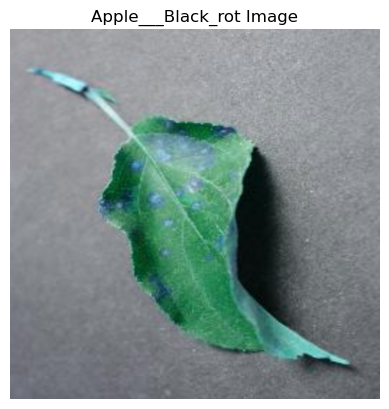

In [2]:
# 1. Set the image path (notice the use of 'r' to handle spaces properly)
img_path = r'./test/AppleCedarRust3.JPG'

# 2. Check if the file exists
if os.path.isfile(img_path):
    # 3. Read and convert the image
    img = cv2.imread(img_path)
    if img is not None:
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Optional: Resize to avoid memory issues
        img = cv2.resize(img, (512, 512))

        # 4. Show the image
        plt.imshow(img)
        plt.axis('off')  # optional: remove axis ticks
        plt.title("Apple___Black_rot Image")
        plt.show()
    else:
        print("Image could not be loaded. It might be corrupted.")
else:
    print("File not found. Please check the path.")


In [3]:
img.shape

(512, 512, 3)

In [31]:
model = models.load_state_dict(torch.load('CNN_Model.pth', map_location=DEVICE))
model.to(DEVICE)

AttributeError: module 'torchvision.models' has no attribute 'load_state_dict'

Predicted class name: Tomato___Bacterial_spot


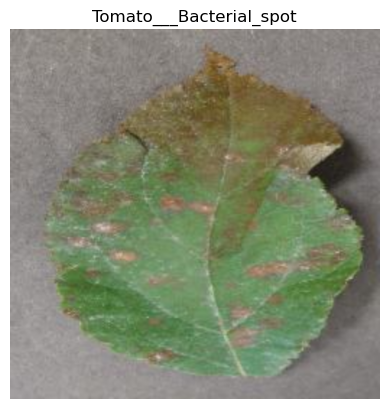

In [ ]:
#img_path = './test/apple_healthy.jpeg'
img_path = './test/AppleCedarRust4.JPG'


# 2. Define the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match model input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Optional: match training normalization
])

# 3. Load and preprocess image
image = Image.open(img_path).convert('RGB')  # ensure 3 channels
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension [1, 3, 128, 128]


# 4. Move to device

image = image.to(DEVICE)

model.eval()  # Set model to evaluation mode

# 5. Make prediction
with torch.no_grad():
    output = model(image)
    predicted_class = output.argmax(dim=1).item()

# 6. Output prediction
print("Predicted class name:", classes[predicted_class])


# 2. Check if the file exists
if os.path.isfile(img_path):
    # 3. Read and convert the image
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Optional: Resize to avoid memory issues
        img = cv2.resize(img, (512, 512))

        # 4. Show the image
        plt.imshow(img)
        plt.axis('off')  # optional: remove axis ticks
        plt.title(classes[predicted_class])
        plt.show()
    else:
        print("Image could not be loaded. It might be corrupted.")
else:
    print("File not found. Please check the path.")

# googlenet CNN framwork

In [10]:
model_googlenet = models.googlenet(pretrained=True)
print(model_googlenet)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:56<00:00, 919kB/s] 

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [11]:
# Replace the classifier layer (fully connected layer)
num_class = 38
int_feature = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(int_feature, num_class)

# model convert into cuda..........
model_googlenet = model_googlenet.to(DEVICE)

In [13]:
summary(model_googlenet, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
       BasicConv2d-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
       BasicConv2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 192, 32, 32]         110,592
       BatchNorm2d-9          [-1, 192, 32, 32]             384
      BasicConv2d-10          [-1, 192, 32, 32]               0
        MaxPool2d-11          [-1, 192, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          12,288
      BatchNorm2d-13           [-1, 64, 16, 16]             128
      BasicConv2d-14           [-1, 64,

In [14]:
# Optimizer and Loss function
# Include parameters of both the classifier and unfrozen layers
learning_rate = 0.0001
optimizer = optim.Adam([
    {'params': model_googlenet.fc.parameters()}
      ], 
  lr=learning_rate, weight_decay=0.0005
  )

criterion = nn.CrossEntropyLoss()

In [20]:
# Training Parameters and Variables............
num_epochs = 10
train_losses =[]
val_losses = []
best_val_loss = float('inf')
patience = 5  # Early stopping patience
trigger_times = 0

for epoch in range(num_epochs):
    model_googlenet.train()
    running_train_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) # move to GPU
        optimizer.zero_grad()  # Zero the parameter gradients
        output = model_googlenet(inputs)  # compute loss
        losses = criterion(output, labels)  # compute loss
        losses.backward()
        optimizer.step()

        running_train_loss += losses

    train_loss = running_train_loss / len(trainloader)
    train_losses.append(train_loss)


    model_googlenet.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)  # Move data to GPU
            outputs = model_googlenet(inputs)
            losses = criterion(outputs, labels)
            running_val_loss += losses.item()

    val_loss = running_val_loss / len(validloader)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        # Save the model checkpoint
        #torch.save(model.state_dict(), 'CNN_Model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break 

# 8. Loading the Best Model

#model.load_state_dict(torch.load('CNN_Model.pth'))

Epoch [1/10], Training Loss: 2.2479, Validation Loss: 1.5810
Epoch [2/10], Training Loss: 1.1962, Validation Loss: 1.1263
Epoch [3/10], Training Loss: 0.9163, Validation Loss: 0.9312
Epoch [4/10], Training Loss: 0.7870, Validation Loss: 0.8153
Epoch [5/10], Training Loss: 0.7073, Validation Loss: 0.7598
Epoch [6/10], Training Loss: 0.6550, Validation Loss: 0.7189
Epoch [7/10], Training Loss: 0.6151, Validation Loss: 0.6660
Epoch [8/10], Training Loss: 0.5929, Validation Loss: 0.6479
Epoch [9/10], Training Loss: 0.5681, Validation Loss: 0.6216
Epoch [10/10], Training Loss: 0.5513, Validation Loss: 0.6236


In [30]:
#img_path = 'G:/Data Science/ML_and_DL_project/CNN_project/Plant_Disease_Dataset_model/test\AppleCedarRust4.JPG'
#img_path = 'G:/Data Science/ML_and_DL_project/CNN_project/Plant_Disease_Dataset_model/test\PotatoEarlyBlight2.JPG'

#img_path = './test/5.jpeg'
#img_path = './test/apple_healthy.jpeg'
#img_path = './test/CornCommonRust3.JPG'
img_path = './test/AppleScab3.JPG'

#img_path = './Dataset/Soybean___healthy/0a45a930-7bf1-40a5-8c36-ddf1296a65a6___RS_HL 4022.JPG'

# 2. Define the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match model input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Optional: match training normalization
])

# 3. Load and preprocess image
image = Image.open(img_path).convert('RGB')  # ensure 3 channels
image = transform(image)
image = image.unsqueeze(0)  # Add batch dimension [1, 3, 128, 128]

# 4. Move to device

image = image.to(DEVICE)

model_googlenet.eval()  # Set model to evaluation mode

# 5. Make prediction
with torch.no_grad():
    output = model_googlenet(image)
    _, predicted = torch.max(output, 1)

# 6. Output prediction
print("Predicted class name:", classes[predicted.item()])


Predicted class name: Squash___Powdery_mildew
